In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(grid=False)

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# set figure size
plt.rcParams["figure.figsize"] = (10,8)
# specify decimal places to display
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from wrangle import wrangle_manila

In [2]:
df = wrangle_manila()
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year,decade
dt,,,,,,,,,
1845-01-01,25.00,1.87,Manila,Philippines,15.27N,120.83E,1,1845,1840
1845-02-01,24.63,2.23,Manila,Philippines,15.27N,120.83E,2,1845,1840
1845-03-01,26.51,1.37,Manila,Philippines,15.27N,120.83E,3,1845,1840
1845-04-01,26.45,0.67,Manila,Philippines,15.27N,120.83E,4,1845,1840
1845-05-01,27.56,1.50,Manila,Philippines,15.27N,120.83E,5,1845,1840


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2025 entries, 1845-01-01 to 2013-09-01
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AverageTemperature             2025 non-null   float64
 1   AverageTemperatureUncertainty  2025 non-null   float64
 2   City                           2025 non-null   object 
 3   Country                        2025 non-null   object 
 4   Latitude                       2025 non-null   object 
 5   Longitude                      2025 non-null   object 
 6   month                          2025 non-null   int64  
 7   year                           2025 non-null   int64  
 8   decade                         2025 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 158.2+ KB


In [4]:
manila = df.drop(columns=['City','Country','Latitude','Longitude'])
manila.head()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1845-01-01,25.00,1.87,1,1845,1840
1845-02-01,24.63,2.23,2,1845,1840
1845-03-01,26.51,1.37,3,1845,1840
1845-04-01,26.45,0.67,4,1845,1840
1845-05-01,27.56,1.50,5,1845,1840


In [5]:
#168 years of data 1845-2013
manila.tail()

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
2013-05-01,29.55,0.25,5,2013,2010
2013-06-01,28.57,0.47,6,2013,2010
2013-07-01,27.27,0.60,7,2013,2010
2013-08-01,26.75,0.38,8,2013,2010
2013-09-01,26.45,0.67,9,2013,2010


# Split

In [6]:
# set train size to be 50% of total 
train_size = int(len(manila) * .5)
train_size

1012

In [7]:
# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

607

In [8]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

406

In [9]:
# validate will go from 1012 to 1012+607
validate_end_index = train_size + validate_size
validate_end_index

1619

In [10]:
# train will go from 0 to 1011
train = manila[: train_size]
# validate will go from 1012 to 1658
validate = manila[train_size:validate_end_index]
# test will include 1619 to the end
test = manila[validate_end_index:]

In [11]:
# is len of train + validate + test == length of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(manila))

True


In [12]:
#Does the first row of original df equate to the first row of train?
print(manila.head(1) == train.head(1))

            AverageTemperature  AverageTemperatureUncertainty  month  year  \
dt                                                                           
1845-01-01                True                           True   True  True   

            decade  
dt                  
1845-01-01    True  


In [13]:
#Is the last row of train the day before the first row of validate? And the same for validate to test?
pd.concat([train.tail(1), validate.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1929-04-01,27.88,0.33,4,1929,1920
1929-05-01,28.56,0.30,5,1929,1920


In [14]:
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
1979-11-01,26.21,0.32,11,1979,1970
1979-12-01,24.61,0.31,12,1979,1970


In [15]:
#Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), manila.tail(1)])

,AverageTemperature,AverageTemperatureUncertainty,month,year,decade
dt,,,,,
2013-09-01,26.45,0.67,9,2013,2010
2013-09-01,26.45,0.67,9,2013,2010


In [16]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'month', 'year',
       'decade'],
      dtype='object')

In [17]:
temp_cols = ['AverageTemperature','AverageTemperatureUncertainty']

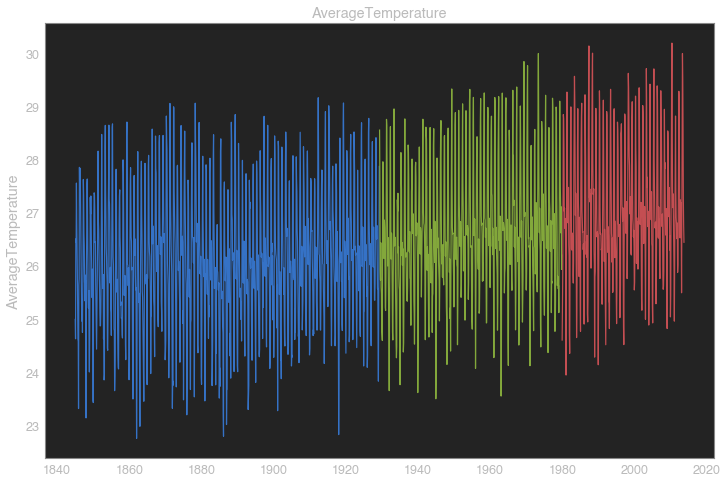

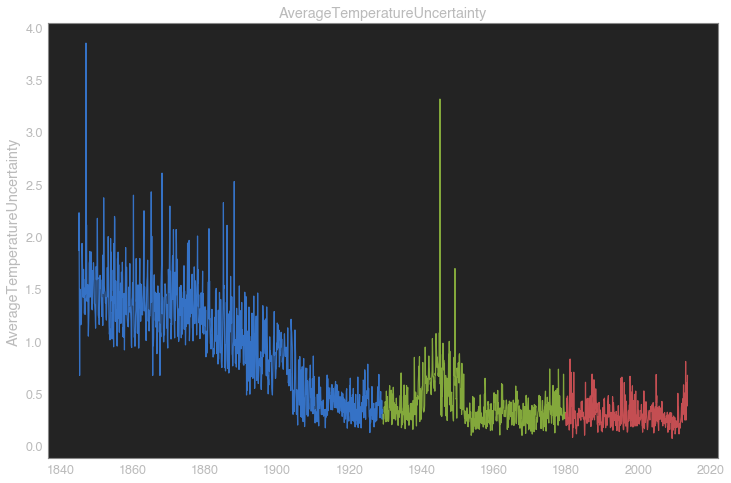

In [18]:
for col in train[temp_cols]:
    plt.figure(figsize=(12,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

array([[<AxesSubplot:title={'center':'AverageTemperature'}>,
        <AxesSubplot:title={'center':'AverageTemperatureUncertainty'}>]],
      dtype=object)

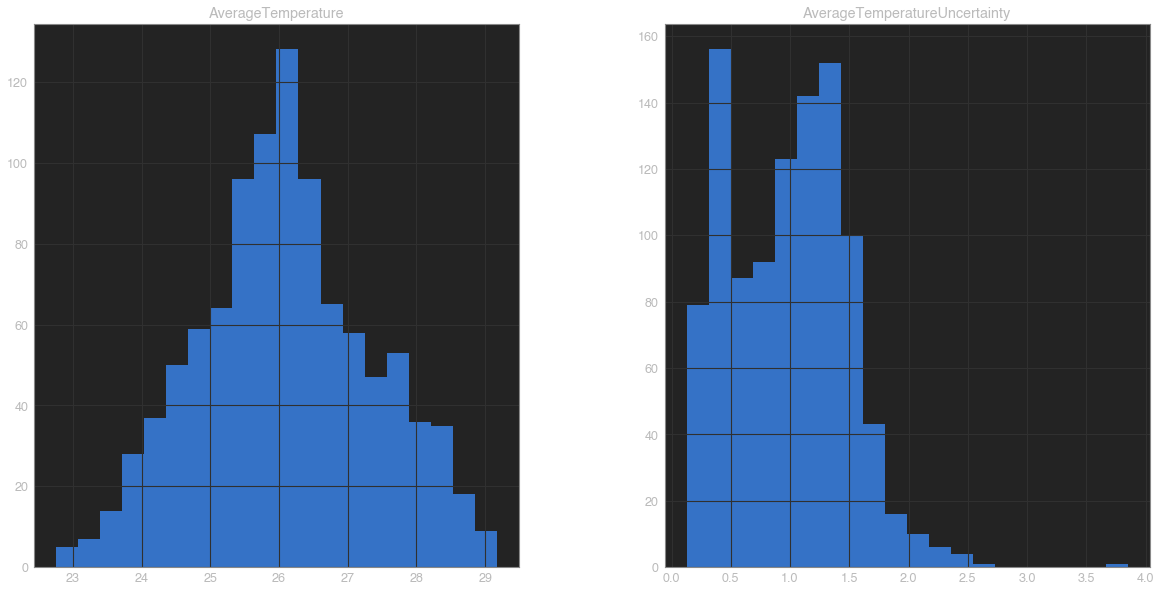

In [19]:
train[temp_cols].hist(bins=20,figsize=(20,10))

In [20]:
train.AverageTemperature.describe()

count   1012.00
mean      26.09
std        1.27
min       22.75
25%       25.26
50%       26.05
75%       26.93
max       29.17
Name: AverageTemperature, dtype: float64

<AxesSubplot:xlabel='month'>

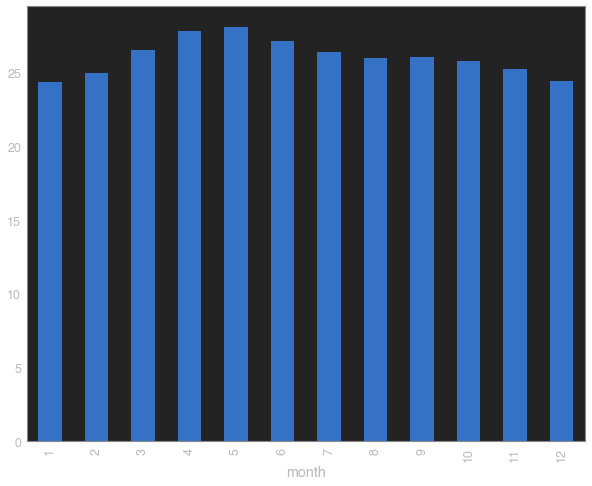

In [21]:
train.groupby('month').AverageTemperature.mean().plot.bar()

<AxesSubplot:xlabel='decade'>

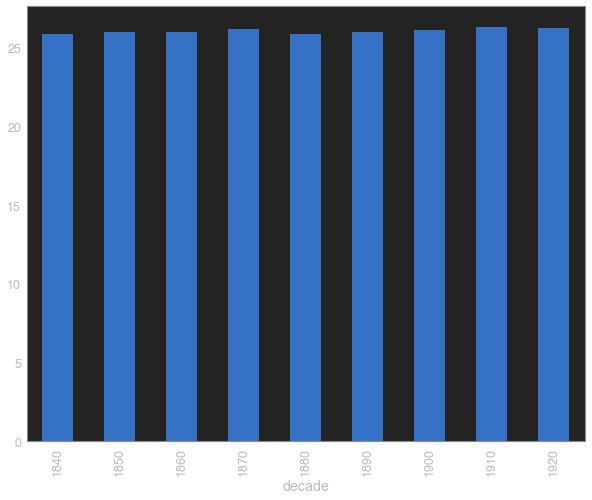

In [22]:
train.groupby('decade').AverageTemperature.mean().plot.bar()

<AxesSubplot:xlabel='month'>

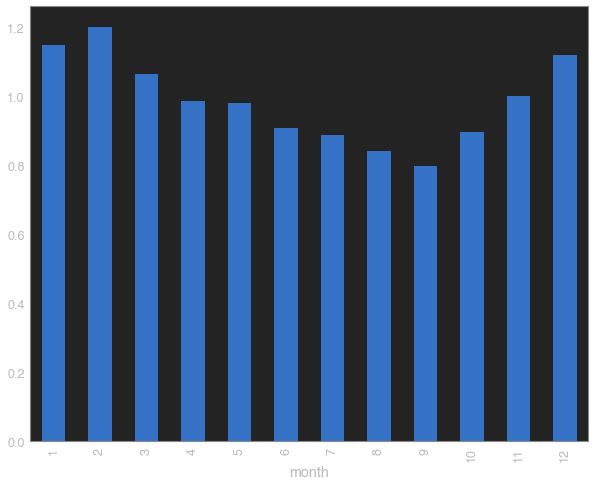

In [23]:
train.groupby('month').AverageTemperatureUncertainty.mean().plot.bar()

Text(6, 28, 'Rainy season June - November')

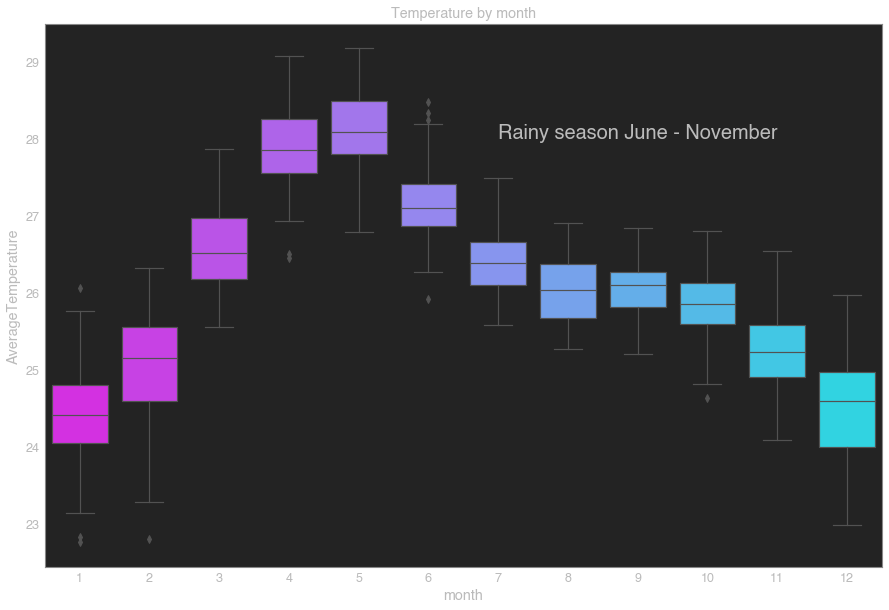

In [28]:
plt.figure(figsize=(15,10))
sns.boxplot(data = train, x='month', y='AverageTemperature', palette='cool_r')
plt.title('Temperature by month')
plt.annotate('Rainy season June - November', (6,28),fontsize=20)

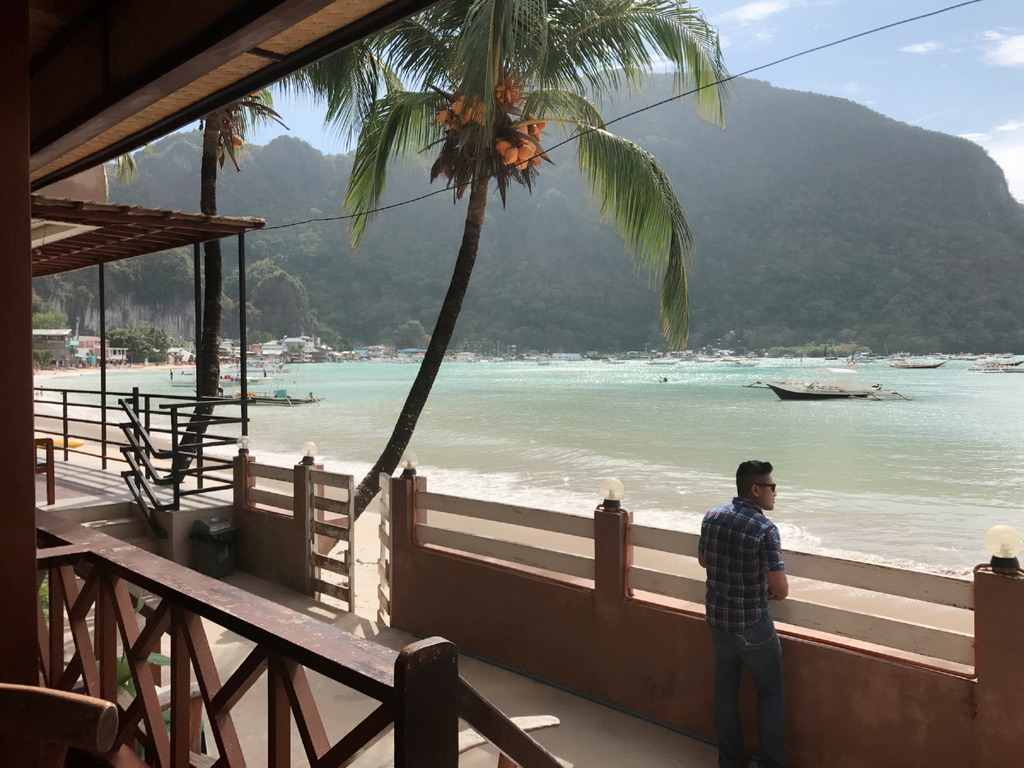

In [30]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "El_Nido.jpeg")

In [ ]:
sns.boxplot(data = train, x='decade', y='AverageTemperature', palette='cool')

In [ ]:
sns.boxplot(data = train, x='month', y='AverageTemperatureUncertainty', palette='cool')

In [ ]:
train.resample('M').mean().AverageTemperature.plot(label = 'Monthly')
train.resample('Y').mean().AverageTemperature.plot(label = 'Yearly')
plt.legend()

In [ ]:
train.resample('Y').AverageTemperature.agg(['min','mean','max']).plot()

In [ ]:
train.resample('5Y').AverageTemperature.agg(['min','mean','max']).plot()

In [ ]:
plt.figure(figsize=(15,10))
train.AverageTemperature.plot(alpha=.2, label='Monthly')
#train.resample('M').mean().AverageTemperature.plot(label='Monthly')
train.resample('Y').mean().AverageTemperature.plot(label='Yearly')
train.resample('10Y').mean().AverageTemperature.plot(label='Decade')
plt.legend()

In [ ]:
train.resample('5Y').AverageTemperature.mean().diff().plot(title = 'Average 5 year change in average temp', figsize = (10,10))

In [ ]:
train.groupby([train.index.year, train.index.month]).AverageTemperature.mean().unstack(0).plot(figsize=(15,10))

In [ ]:
table = train.groupby([train.index.year, train.index.month]).AverageTemperature.mean().unstack()
table

In [ ]:
fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month,figsize = (25,10))
    x_left, x_right = ax.get_xlim()
    ax.hlines(subset.mean(), x_left, x_right, ls='--')
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

In [ ]:
y = train.AverageTemperature

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y, y.shift(-1))
plt.xlabel('$y_t$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag = 1')

In [ ]:
# Plot the weekly average & the 7-day moving average. Compare the 2 plots.
#plt.style.use('fivethirtyeight')
#plt.figure(figsize=(10,10))
jtplot.style(figsize=(15,10))
y.resample('Y').mean().plot(label='Resampled Yearly', alpha=.6, lw=3)
y.rolling(12).mean().plot(label='Rolling Yearly Average', alpha=0.7, color='orange')
plt.legend()

In [ ]:
pd.plotting.autocorrelation_plot(train.AverageTemperature.resample('2M').mean())

In [ ]:
y = train.AverageTemperature.resample('Y').mean()

result = sm.tsa.seasonal_decompose(y)
result

In [ ]:
result.seasonal

In [ ]:
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

In [ ]:
decomposition.iloc[:, 1:].plot()

In [ ]:
# the value returned from seasonal_decompose can itself be plotted:
plt.rc('figure', figsize=(13, 7))
result.plot()
None

In [ ]:
# create a categorical feature
train['temp_bin'] = pd.qcut(train.AverageTemperature, 4, labels=['low', 'med_low', 'med_high', 'high'])
train.groupby('temp_bin').AverageTemperature.mean()

In [ ]:
train.head()

In [ ]:
jtplot.style(grid=False,figsize=(10,10))
(train[:'1850'].groupby('temp_bin')
 .resample('M')
 .size() # like COUNT(*)
 .unstack(0) # turns an index level into columns
 .fillna(0)
 .astype(int)
 .apply(lambda row: row / row.sum(), axis=1) # raw nums to % of the row
 .plot.area()
)
plt.ylabel('% of days in the month')

In [ ]:
ax = (train['1927':'1929']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
# take the existing labels, convert them to Timestamps, and then reformat with .strftime
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels);

# Modeling

In [ ]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

In [ ]:
from evaluate import plot_and_eval, append_eval_df

### Last observed value (baseline)

In [ ]:
temp = round(train['AverageTemperature'][-1:][0], 2)
temp

In [ ]:
yhat_df = pd.DataFrame({'AverageTemperature': [temp]},index = validate.index)
yhat_df.head()

In [ ]:
yhat_df.describe()

In [ ]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [ ]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='last_observed_value',
                         target_var='AverageTemperature')

eval_df

### Simple Average

In [ ]:
# compute simple average
temp = round(train['AverageTemperature'].mean(),2)
temp

In [ ]:
def make_predictions():
    yhat_df = pd.DataFrame(
        {'AverageTemperature': [temp]},
        index=validate.index)
    return yhat_df


In [ ]:
yhat_df = make_predictions()
yhat_df.head()

In [ ]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [ ]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='simple_average',
                         target_var='AverageTemperature')

eval_df

# Moving Average

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(train['AverageTemperature'].rolling(7).mean())
plt.plot(train['AverageTemperature'].rolling(30).mean())
plt.plot(train['AverageTemperature'].rolling(90).mean())
plt.plot(train['AverageTemperature'].rolling(120).mean())
plt.plot(train['AverageTemperature'], alpha=.3)

In [ ]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['AverageTemperature'].rolling(30).mean()[29])
print(train['AverageTemperature'].head(30).mean())

In [ ]:
period = 24 

# take 24 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
temp = round(train['AverageTemperature'].rolling(period).mean()[-1], 2)
print(temp)

In [ ]:
yhat_df = make_predictions()
yhat_df.head()

In [ ]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [ ]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='24m_moving_average',
                         target_var='AverageTemperature')

eval_df

# Previous Cycle

In [ ]:
#Re-split data

train = manila['2008':'2010'][['AverageTemperature']]
validate = manila['2011'][['AverageTemperature']]
test = manila['2012'][['AverageTemperature']]

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

In [ ]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2010'] + train.diff(12).mean()
yhat_df

In [ ]:
train.loc['2010'].head()

In [ ]:
# let's peek into the prediction we will make for 1/1/2011
# by comparing the predicted value 
# (2010 value + year-over-year average difference)
# to the actual 1/1/2010 value
pd.concat([yhat_df.head(1), validate.head(1)])

In [ ]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

In [ ]:
yhat_df.describe()

In [ ]:
yhat_df.head()

In [ ]:
yhat_df.shape

In [ ]:
plot_and_eval(train,validate,yhat_df,'AverageTemperature')

In [ ]:
eval_df = append_eval_df(validate,
                         eval_df,
                         yhat_df,
                         model_type='previous_year',
                         target_var='AverageTemperature')

eval_df